In [9]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
def to_sequences(seq_size, data):
    x = []
    y = []
#data has individual records but you want your model to be based on a sequence of days. 
    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)    


#Print stats and plots for a model
def model_report(pred,y_test):
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score))
    chart_regression(pred.flatten(),y_test)
    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [10]:
    
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

df = pd.read_csv("./data/CSC215_P2_Stock_Price.csv")
df.drop(columns=['Adj_Close'], inplace=True)
df['Date']= pd.to_datetime(df['Date']) 
df.sort_values(by=['Date'])
dfclose = df['Close'].copy(deep=True)
encode_numeric_range(df,'Open')
encode_numeric_range(df,'High')
encode_numeric_range(df,'Low')
encode_numeric_range(df,'Close')
encode_numeric_range(df,'Volume')
df.insert(6,'True_Close',dfclose)
#split along year, for sequential analysis
#dftrain=df[df['Date']<='2010/12/31']
#dftest=df[df['Date']>='2011/01/01']
print(df.shape)
df[0:1]

(4392, 7)


,Date,Open,High,Low,Close,Volume,True_Close
0,2000-03-27,-0.991245,-0.987063,-0.986131,-0.985183,-0.849198,4.125


In [11]:

# Split into train/test
import math
# Split into train/test
size = df.shape[0]
print(size)
trainsize= math.floor(size*.7)
dftrain = df.head(trainsize)
dftest = df.tail(size-trainsize)
print("dftrain is{}")
print("{}".format(dftrain[0:16]))

SEQUENCE_SIZE=7;

dftrain_yonly=dftrain[['Date','True_Close']]
dftest_yonly=dftest[['Date','True_Close']]
dftrain_yonly.drop(columns=['Date'], inplace=True)
dftest_yonly.drop(columns=['Date'],inplace=True)
dftrain.drop(columns=['Date','True_Close'], inplace=True)
dftest.drop(columns=['Date','True_Close'], inplace=True)
data = dftrain.to_numpy()
datay = dftrain_yonly.to_numpy()
x_train,y_train = to_sequences(SEQUENCE_SIZE,data)
xthrow,y_train = to_sequences(SEQUENCE_SIZE,datay)
#print("Shape of xtrain b4 {}" .format(x_train.shape))
#print("Shape of ytrain b4{}" .format(y_train.shape))
data = dftest.to_numpy()
datay = dftest_yonly.to_numpy()
x_test,y_test = to_sequences(SEQUENCE_SIZE,data)
xthrowaway,y_test = to_sequences(SEQUENCE_SIZE,datay)

print("x train is {}" )
#print(x_train[0:16])
print("y train is {}")
#print(y_train[0:16])

print("Shape of xtest b4 {}" .format(x_test.shape))
print("Shape of ytest b4{}" .format(y_test.shape))
x_train = np.reshape(x_train,(x_train.shape[0],7,5)) #x_train = np.reshape(x,(x.shape[0],x.shape[1],x.shape[3]))
x_test = np.reshape(x_test,(x_test.shape[0],7,5))
print("Shape of xtest after {}" .format(x_test.shape))
print("Shape of xtrain after{}" .format(x_train.shape))


4392
dftrain is{}
         Date      Open      High       Low     Close    Volume  True_Close
0  2000-03-27 -0.991245 -0.987063 -0.986131 -0.985183 -0.849198    4.125000
1  2000-03-28 -0.985938 -0.987591 -0.982931 -0.987035 -0.961612    4.015625
2  2000-03-29 -0.988061 -0.989175 -0.983731 -0.987300 -0.989321    4.000000
3  2000-03-30 -0.988061 -0.989703 -0.985598 -0.989946 -0.926737    3.843750
4  2000-03-31 -0.992571 -0.994191 -0.993332 -0.997619 -0.665044    3.390625
5  2000-04-03 -0.996551 -0.994719 -0.992532 -0.996825 -0.511213    3.437500
6  2000-04-04 -0.996020 -0.996832 -0.998400 -0.995767 -0.439819    3.500000
7  2000-04-05 -0.997082 -0.997096 -0.992266 -0.996031 -0.733496    3.484375
8  2000-04-06 -0.996551 -0.996568 -0.991999 -0.994444 -0.697513    3.578125
9  2000-04-07 -0.994959 -0.992871 -0.989865 -0.993915 -0.406588    3.609375
10 2000-04-10 -0.993367 -0.993927 -0.989332 -0.993385 -0.779742    3.640625
11 2000-04-11 -0.995224 -0.995512 -0.990399 -0.994444 -0.723094    3.5

C:\Apps\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


x train is {}
y train is {}
Shape of xtest b4 (1310, 7, 1, 5)
Shape of ytest b4(1310, 1)
Shape of xtest after (1310, 7, 5)
Shape of xtrain after(3066, 7, 5)


Build model...
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 15s - loss: 225.8510 - val_loss: 1417.4992
Epoch 2/100
3066/3066 - 10s - loss: 49.4317 - val_loss: 786.9036
Epoch 3/100
3066/3066 - 4s - loss: 28.9541 - val_loss: 132.2352
Epoch 4/100
3066/3066 - 2s - loss: 20.5819 - val_loss: 221.9020
Epoch 5/100
3066/3066 - 2s - loss: 19.6416 - val_loss: 159.8455
Epoch 6/100
3066/3066 - 2s - loss: 16.8245 - val_loss: 105.2044
Epoch 7/100
3066/3066 - 2s - loss: 14.3278 - val_loss: 66.2377
Epoch 8/100
3066/3066 - 2s - loss: 13.3865 - val_loss: 133.7562
Epoch 9/100
3066/3066 - 2s - loss: 13.0814 - val_loss: 59.5244
Epoch 10/100
3066/3066 - 2s - loss: 11.1076 - val_loss: 105.7143
Epoch 11/100
3066/3066 - 2s - loss: 10.2843 - val_loss: 59.6251
Epoch 12/100
3066/3066 - 2s - loss: 9.7994 - val_loss: 71.8381
Epoch 13/100
3066/3066 - 2s - loss: 8.6043 - val_loss: 66.4715
Epoch 14/100
3066/3066 - 2s - loss: 8.0436 - val_loss: 77.6795
Epoch 00014: early stopping
Scor

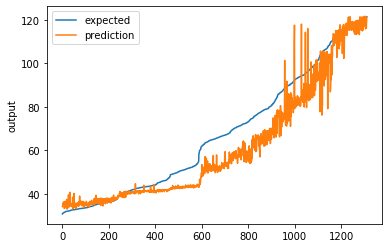

In [8]:
#Model 1
print('Build model...')
model = Sequential()

model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=x_train[1].shape))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=adam)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, epochs=100)  

pred = model.predict(x_test)
y_test.shape
model_report(pred,y_test)

Build model...
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 5s - loss: 145.4493 - val_loss: 59472.6042
Epoch 2/100
3066/3066 - 3s - loss: 34.3450 - val_loss: 1551.8944
Epoch 3/100
3066/3066 - 3s - loss: 16.5822 - val_loss: 39.5295
Epoch 4/100
3066/3066 - 3s - loss: 13.3408 - val_loss: 407.5320
Epoch 5/100
3066/3066 - 3s - loss: 10.3468 - val_loss: 1090.6415
Epoch 6/100
3066/3066 - 4s - loss: 9.3885 - val_loss: 232.2744
Epoch 7/100
3066/3066 - 3s - loss: 8.5225 - val_loss: 574.0193
Epoch 8/100
3066/3066 - 3s - loss: 7.2348 - val_loss: 791.3551
Epoch 00008: early stopping
Score (RMSE): 28.131034476819142


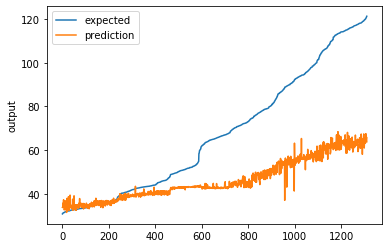

In [9]:
#Model 1b
print('Build model...')
model = Sequential()

model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=x_train[1].shape,return_sequences=True))
model.add(LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=adam)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, epochs=100)  

pred = model.predict(x_test)
y_test.shape
model_report(pred,y_test)

Build model...
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 6s - loss: 428256.8674 - val_loss: 5309.4486
Epoch 2/100
3066/3066 - 2s - loss: 340.6293 - val_loss: 5309.4486
Epoch 3/100
3066/3066 - 3s - loss: 340.6293 - val_loss: 5309.4485
Epoch 4/100
3066/3066 - 3s - loss: 340.6293 - val_loss: 5309.4485
Epoch 5/100
3066/3066 - 2s - loss: 340.6293 - val_loss: 5309.4485
Epoch 6/100
3066/3066 - 2s - loss: 340.6293 - val_loss: 5309.4486
Epoch 00006: early stopping
Score (RMSE): 72.86596295638316


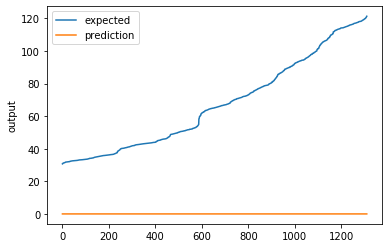

In [17]:
#Model 1c
print('Build model...')
model = Sequential()

model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=x_train[1].shape,return_sequences=True))
model.add(LSTM(128, activation='relu', dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, epochs=100)  

pred = model.predict(x_test)
y_test.shape
model_report(pred,y_test)

Build model...
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 5s - loss: 173.2407 - val_loss: 2252.5967
Epoch 2/100
3066/3066 - 1s - loss: 45.5352 - val_loss: 265.9799
Epoch 3/100
3066/3066 - 1s - loss: 32.4423 - val_loss: 136.9572
Epoch 4/100
3066/3066 - 1s - loss: 23.5606 - val_loss: 101.0097
Epoch 5/100
3066/3066 - 1s - loss: 21.8124 - val_loss: 69.3178
Epoch 6/100
3066/3066 - 1s - loss: 18.0875 - val_loss: 96.1968
Epoch 7/100
3066/3066 - 1s - loss: 15.8787 - val_loss: 194.4509
Epoch 8/100
3066/3066 - 1s - loss: 13.5817 - val_loss: 326.2764
Epoch 9/100
3066/3066 - 1s - loss: 13.0555 - val_loss: 164.6404
Epoch 10/100
3066/3066 - 1s - loss: 12.5305 - val_loss: 145.9349
Epoch 00010: early stopping
Score (RMSE): 12.080349766286337


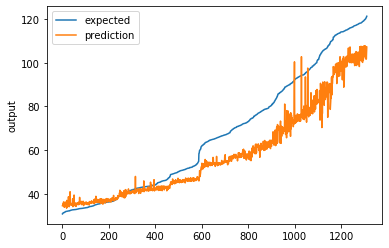

In [20]:
#Model 1d
print('Build model...')
model = Sequential()
checkpointer = ModelCheckpoint(filepath="dnn/lstm_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=x_train[1].shape))
model.add(Dense(22, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=adam)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=100)  

pred = model.predict(x_test)
y_test.shape
model_report(pred,y_test)

Build model...
0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 2s - loss: 216.7254 - val_loss: 575.5976
Epoch 2/100
3066/3066 - 1s - loss: 58.4817 - val_loss: 118.2178
Epoch 3/100
3066/3066 - 1s - loss: 25.6819 - val_loss: 65.6455
Epoch 4/100
3066/3066 - 1s - loss: 19.1209 - val_loss: 141.8165
Epoch 5/100
3066/3066 - 1s - loss: 15.9160 - val_loss: 185.8264
Epoch 6/100
3066/3066 - 1s - loss: 15.8660 - val_loss: 358.2472
Epoch 7/100
3066/3066 - 2s - loss: 12.0447 - val_loss: 231.3374
Epoch 8/100
3066/3066 - 1s - loss: 11.7419 - val_loss: 387.1438
Epoch 00008: early stopping
1
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 2s - loss: 186.1488 - val_loss: 1339.6604
Epoch 2/100
3066/3066 - 1s - loss: 44.1882 - val_loss: 88.2028
Epoch 3/100
3066/3066 - 1s - loss: 23.1105 - val_loss: 30.2393
Epoch 4/100
3066/3066 - 1s - loss: 17.4183 - val_loss: 265.4354
Epoch 5/100
3066/3066 - 1s - loss: 14.8658 - val_loss: 165.9646
Epoch 6

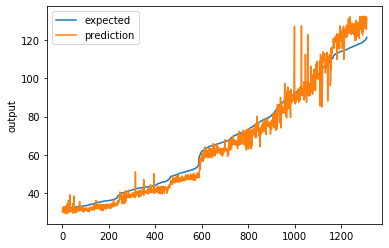

In [5]:
#Model 1e
print('Build model...')
checkpointer = ModelCheckpoint(filepath="dnn/lstm_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    print(i)

    model = Sequential()

    model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=x_train[1].shape))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=100)  

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/lstm_weights.hdf5') # load weights from best model
pred = model.predict(x_test)
model_report(pred,y_test)

Build model...
Train...
Train on 3066 samples, validate on 1310 samples


W1008 22:49:12.022795 20784 deprecation.py:506] From C:\Apps\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/100
3066/3066 - 4s - loss: 320.0187 - val_loss: 5244.7171
Epoch 2/100
3066/3066 - 1s - loss: 249.3753 - val_loss: 5159.0542
Epoch 3/100
3066/3066 - 1s - loss: 232.5841 - val_loss: 5102.0507
Epoch 4/100
3066/3066 - 1s - loss: 218.1158 - val_loss: 5023.0125
Epoch 5/100
3066/3066 - 1s - loss: 206.3741 - val_loss: 4923.1672
Epoch 6/100
3066/3066 - 1s - loss: 189.8382 - val_loss: 4767.2528
Epoch 7/100
3066/3066 - 1s - loss: 179.9429 - val_loss: 4564.8978
Epoch 8/100
3066/3066 - 1s - loss: 166.8849 - val_loss: 4270.4936
Epoch 9/100
3066/3066 - 1s - loss: 154.0100 - val_loss: 3839.7398
Epoch 10/100
3066/3066 - 1s - loss: 141.3349 - val_loss: 3218.8837
Epoch 11/100
3066/3066 - 1s - loss: 132.0410 - val_loss: 2551.8880
Epoch 12/100
3066/3066 - 1s - loss: 120.4446 - val_loss: 1884.0558
Epoch 13/100
3066/3066 - 1s - loss: 116.4781 - val_loss: 1388.9220
Epoch 14/100
3066/3066 - 1s - loss: 104.7796 - val_loss: 989.8304
Epoch 15/100
3066/3066 - 1s - loss: 109.6181 - val_loss: 875.4033
Epoch 

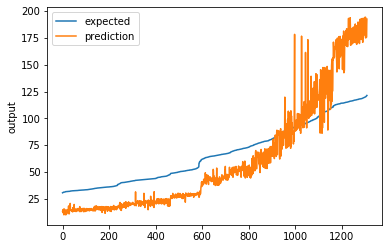

In [16]:
#Model 1f
print('Build model...')
checkpointer = ModelCheckpoint(filepath="dnn/lstm_weightsf.hdf5", verbose=0, save_best_only=True) # save best model
model = Sequential()
model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=x_train[1].shape))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adagrad')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=100)  

pred = model.predict(x_test)
y_test.shape
model_report(pred,y_test)

Build model...
0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 7s - loss: 129.1789 - val_loss: 4133.5252
Epoch 2/100
3066/3066 - 2s - loss: 79.0694 - val_loss: 3720.4404
Epoch 3/100
3066/3066 - 3s - loss: 43.9212 - val_loss: 3550.1911
Epoch 4/100
3066/3066 - 2s - loss: 33.0985 - val_loss: 3488.7267
Epoch 5/100
3066/3066 - 2s - loss: 28.1544 - val_loss: 3481.9750
Epoch 6/100
3066/3066 - 3s - loss: 25.3324 - val_loss: 3459.0053
Epoch 7/100
3066/3066 - 4s - loss: 23.3333 - val_loss: 3439.8331
Epoch 8/100
3066/3066 - 3s - loss: 22.4563 - val_loss: 3429.0490
Epoch 9/100
3066/3066 - 3s - loss: 20.7906 - val_loss: 3451.3644
Epoch 10/100
3066/3066 - 3s - loss: 21.1422 - val_loss: 3331.1323
Epoch 11/100
3066/3066 - 4s - loss: 20.5416 - val_loss: 3486.2465
Epoch 12/100
3066/3066 - 3s - loss: 19.1428 - val_loss: 3499.1037
Epoch 13/100
3066/3066 - 3s - loss: 19.4995 - val_loss: 3251.5968
Epoch 14/100
3066/3066 - 3s - loss: 18.9446 - val_loss: 3495.9272
Epoch 15/1

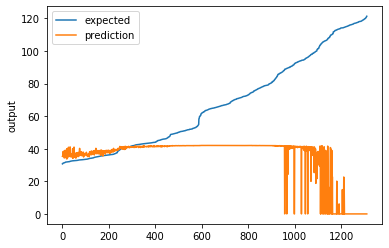

In [21]:
#Model 1g
print('Build model...')
checkpointer = ModelCheckpoint(filepath="dnn/lstm_weightse.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    print(i)

    model = Sequential()

    model.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0.2, input_shape=x_train[1].shape))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=100)  

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/lstm_weightse.hdf5') # load weights from best model
pred = model.predict(x_test)
model_report(pred,y_test)

Build model...
0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 12s - loss: 162.6229 - val_loss: 563.9889
Epoch 2/100
3066/3066 - 4s - loss: 32.2423 - val_loss: 250.5600
Epoch 3/100
3066/3066 - 5s - loss: 16.4577 - val_loss: 21.6173
Epoch 4/100
3066/3066 - 5s - loss: 13.4624 - val_loss: 154.0411
Epoch 5/100
3066/3066 - 5s - loss: 11.1143 - val_loss: 311.5116
Epoch 6/100
3066/3066 - 4s - loss: 9.9028 - val_loss: 258.9556
Epoch 7/100
3066/3066 - 5s - loss: 8.9450 - val_loss: 185.8302
Epoch 8/100
3066/3066 - 4s - loss: 8.2932 - val_loss: 156.5390
Epoch 00008: early stopping
1
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 12s - loss: 126.5272 - val_loss: 25940.6997
Epoch 2/100
3066/3066 - 4s - loss: 24.7858 - val_loss: 1265.1316
Epoch 3/100
3066/3066 - 4s - loss: 12.9069 - val_loss: 621.1232
Epoch 4/100
3066/3066 - 5s - loss: 8.9085 - val_loss: 159.7648
Epoch 5/100
3066/3066 - 5s - loss: 7.6372 - val_loss: 80.0493
Epoch 6

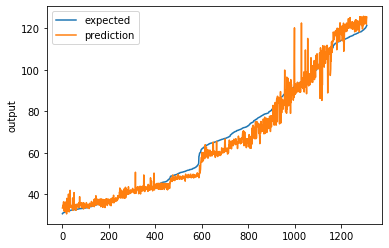

In [22]:
#Model 1h
print('Build model...')
checkpointer = ModelCheckpoint(filepath="dnn/lstm_weightsh.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    print(i)

    model = Sequential()

    model.add(LSTM(128, activation='relu', dropout=0.1, recurrent_dropout=0.1, input_shape=x_train[1].shape,return_sequences=True))
    model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=100)  

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/lstm_weightsh.hdf5') # load weights from best model
pred = model.predict(x_test)
model_report(pred,y_test)

Build model...
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 27s - loss: 117.9797 - val_loss: 11066.9917
Epoch 2/100
3066/3066 - 8s - loss: 23.9083 - val_loss: 5522.3055
Epoch 3/100
3066/3066 - 6s - loss: 9.2849 - val_loss: 2439.4898
Epoch 4/100
3066/3066 - 7s - loss: 6.7937 - val_loss: 1061.7075
Epoch 5/100
3066/3066 - 7s - loss: 5.8100 - val_loss: 846.2217
Epoch 6/100
3066/3066 - 7s - loss: 5.5678 - val_loss: 346.2768
Epoch 7/100
3066/3066 - 7s - loss: 5.2963 - val_loss: 89.4500
Epoch 8/100
3066/3066 - 6s - loss: 4.5698 - val_loss: 75.3832
Epoch 9/100
3066/3066 - 7s - loss: 4.3392 - val_loss: 78.0127
Epoch 10/100
3066/3066 - 6s - loss: 3.7979 - val_loss: 69.2852
Epoch 11/100
3066/3066 - 6s - loss: 3.6144 - val_loss: 73.2458
Epoch 12/100
3066/3066 - 7s - loss: 3.5845 - val_loss: 132.7669
Epoch 13/100
3066/3066 - 6s - loss: 3.2804 - val_loss: 344.3348
Epoch 14/100
3066/3066 - 6s - loss: 3.1464 - val_loss: 172.0599
Epoch 15/100
3066/3066 - 5s - loss: 3

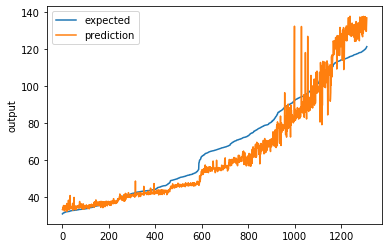

In [29]:
#Model 1i
from tensorflow.keras.layers import Bidirectional
print('Build model...')
checkpointer = ModelCheckpoint(filepath="dnn/lstm_weightsi.hdf5", verbose=0, save_best_only=True) # save best model


model = Sequential()

model.add(Bidirectional(LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.1, input_shape=x_train[1].shape,return_sequences=True)))
model.add(Bidirectional(LSTM(32,activation='relu',dropout=0.2, recurrent_dropout=0.2,)))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=adam)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=100)  

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/lstm_weightsi.hdf5') # load weights from best model
pred = model.predict(x_test)
model_report(pred,y_test)

Build model...
0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 27s - loss: 146.8116 - val_loss: 12713.0289
Epoch 2/100
3066/3066 - 7s - loss: 26.3727 - val_loss: 1384.1929
Epoch 3/100
3066/3066 - 7s - loss: 13.5141 - val_loss: 347.4676
Epoch 4/100
3066/3066 - 7s - loss: 9.9449 - val_loss: 86.6386
Epoch 5/100
3066/3066 - 6s - loss: 7.5756 - val_loss: 89.6184
Epoch 6/100
3066/3066 - 6s - loss: 7.1024 - val_loss: 61.4595
Epoch 7/100
3066/3066 - 6s - loss: 6.1906 - val_loss: 193.5346
Epoch 8/100
3066/3066 - 7s - loss: 5.3381 - val_loss: 117.8284
Epoch 9/100
3066/3066 - 7s - loss: 5.2768 - val_loss: 56.7089
Epoch 10/100
3066/3066 - 6s - loss: 4.6613 - val_loss: 70.3466
Epoch 11/100
3066/3066 - 7s - loss: 4.0564 - val_loss: 98.1420
Epoch 12/100
3066/3066 - 7s - loss: 3.8465 - val_loss: 54.0373
Epoch 13/100
3066/3066 - 7s - loss: 3.7531 - val_loss: 51.7896
Epoch 14/100
3066/3066 - 8s - loss: 3.3927 - val_loss: 68.6907
Epoch 15/100
3066/3066 - 8s - loss: 3.28

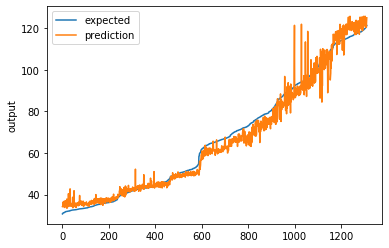

In [30]:
#Model 1j
from tensorflow.keras.layers import Bidirectional
print('Build model...')
checkpointer = ModelCheckpoint(filepath="dnn/lstm_weightsj.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    print(i)
    model = Sequential()

    model.add(Bidirectional(LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.1, input_shape=x_train[1].shape,return_sequences=True)))
    model.add(Bidirectional(LSTM(32,activation='relu',dropout=0.2, recurrent_dropout=0.2,)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=100)  

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/lstm_weightsj.hdf5') # load weights from best model
pred = model.predict(x_test)
model_report(pred,y_test)